## Deep reinforcement learning

### Summary and setup

TBC - GitHub codespaces?

### Questions

- How can an agent learn when state-action spaces do not suit a tabular Q-function format, e.g. due to continuous variables?
- What are the strengths and weaknesses of using neural networks for Q learning?

### Objectives

- Understand how to implement and train a neural network for Q-function approximation using PyTorch
- Learn why this approach can lead to stability problems and what to do about this

### Prerequisites

- TBC


### 1. Introduction

In the previous session, we trained an agent to navigate an environment with a limited set of possible states and actions: it could move either up, down, left or right and be in one of 48 squares. This time, our agent will have a much trickier challenge: although it will be able to take only three possible actions, the observation space is much larger, comprising of continuous - rather than discrete - values. 

For more information about this environment, which is called "Acrobot", please see the [documentation on the gymnasium library's website](https://gymnasium.farama.org/environments/classic_control/acrobot/). 


In [1]:
import gymnasium as gym

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn.objects as so
import math
import random
from collections import namedtuple, deque
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

%matplotlib widget

### Network construction

Deep neural networks can be trained to approximate any function with a degree of accuracy dictated by the number of neurons in the network, including the "Q function" whose purpose is to determine an agent's optimum action from the state of the environment it is in. 

We begin by creating a Python class that inherits from PyTorch's base class for neural network modules. For the purposes of this demonstration, we use a simple feed-forward network with two hidden layers.

In [2]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, layer1_size=64, layer2_size=64):
        """Initialize parameters and build model.
        
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            layer1_size (int): Number of nodes in first hidden layer
            layer2_size (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__() ## calls __init__ method of nn.Module class
        self.layer1 = nn.Linear(state_size, layer1_size)
        self.layer2 = nn.Linear(layer1_size, layer2_size)
        self.layer3 = nn.Linear(layer2_size, action_size)

    def forward(self, x):
        # x = state
        """Build a network that maps state -> action values."""
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In general, computation with PyTorch will run faster on GPUs that support CUDA, but PyTorch code is often written such that it will also run (more slowly) on CPUs. To this end, it is common practice to keep track of which category of device the code is running on:

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Memory

To learn, our agent will need to remember where it has been and what response it got from the environment from the actions it took, and we create a buffer class to perform this function. Our class will need methods to save experiences and take a random sample of existing memories from the buffer, before optimising how PyTorch will use the data in the sample with a call to the `Tensor.to` method and the `device` variable we set in the previous cell. 

It makes use of a couple of helpers from Python's `collections` module: `deque`, which is similar to a `list` but can be set to have a maximum length - in our case the `buffer_size` - and `namedtuple`, which makes `tuple`s more readable by enabling access to their data as named fields (rather than just by a numeric index). 

In [4]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state",
                                                                "action",
                                                                "reward",
                                                                "next_state",
                                                                "done"])

    def add(self,state, action, reward, next_state,done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory"""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### Parameters

We can dictate how the agent learns from its environment by tweaking the following parameters. The discount factor and learning rate parameters are familiar from the previous session, and the meaning of the buffer and batch size parameters should be clear from the `ReplayBuffer` definition above. There will be more detail on `TAU` and `UPDATE_EVERY` shortly.

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network

### Agent

We are now in a position to create a deep Q network (DQN) agent, which will contain two Q networks and a memory. Here the Q networks are structured so that the input is an observed state and the output is a vector of the predicted Q values for all actions when in that state.

In [6]:
class DQN_agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """

        self.state_size = state_size
        self.action_size = action_size
       
        # Q-networks
        self.qnetwork = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)

        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

We give the agent a method for reducing its rate of exploration of the environment over time - the theory being that the more the agent learns about its environment the less useful it will be to take a random action - i.e. the emphasis shifts from exploration to exploitation. 

In [7]:
def get_explore_rate(self, episode, decay):
    """Calculates the logarithmically decreasing explore rate

    Params
    ======
        episode (int): the current episode
        decay (float): controls the rate of decay of the explore rate
    
    Returns
    =======
        explore_rate (float): the epsilon in the agent's epsilon-greedy policy
    """

    # Input validation
    if not 0 < decay:
        raise ValueError("decay needs to be above 0")
    
    # Ensure rate returned is between 0 and 1:
    min_explore_rate = 0
    max_explore_rate = 1
    explore_rate = 1.0 - math.log10(episode / decay)
    return max(min_explore_rate, min(max_explore_rate, explore_rate))

DQN_agent.get_explore_rate = get_explore_rate

As with the agent that learned the tabular Q function in the previous session, here we also use the concept of an epsilon-greedy policy - slightly modified to incorporate the neural networks. First we predict the values for each action in the current state using the Q network. Then with probability `1 - epsilon` we return the action with the highest value and with probability `epsilon` we return a random action. 

In [8]:
def epsilon_greedy_policy(self, state, epsilon=0):
    """Returns action for given state as per current policy

    Params
    ======
        state (array_like): current state
        epsilon (float): for epsilon-greedy action selection
    """

    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork.eval()
    with torch.no_grad():
        action_values = self.qnetwork(state)
    self.qnetwork.train()

    # Epsilon-greedy action selction
    if random.random() > epsilon:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

DQN_agent.policy = epsilon_greedy_policy

The function to update the target network is as follows. There is a distinction between hard updates (updating the target network weights to be a copy of the Q network weights) and soft updates (updating the target network weights to move closer to the Q network weights). Here the strength of the update can be tuned with parameter `TAU`, where `TAU = 1` will result in a hard update. In the early days of DQN very infrequent hard updates were usually used, but now more frequent soft updates are favoured. 

In [9]:
def update_target(self, model, target_model):
    """Soft update model parameters.
    θ_target = τ * θ_local + (1 - τ) * θ_target

    Params
    =======
        local model (PyTorch model): weights will be copied from
        target model (PyTorch model): weights will be copied to
    """
    for target_param, local_param in zip(target_model.parameters(), model.parameters()):
        target_param.data.copy_(TAU*local_param.data + (1-TAU)*target_param.data)
  
DQN_agent.update_target = update_target    

Now we can write the `update_Q` function to train our Q network. This function takes a sample of `experiences` from the agent's memory as input and uses the discount factor, `GAMMA`, defined in the parameters section above. First we use the target network to predict the future return from the `next_states` in the sample of experiences. Then we construct the Q learning targets using these future predictions, the observed reward and `GAMMA`, just like in the tabular methods. Next we train the Q network using the loss between these targets and the predicted targets given by the current Q network weights. Finally we do our target network update.

In [10]:
def update_Q(self, experiences):
    """Update value parameters using given batch of experience tuples.
    
    Params
    =======
        experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
    """
    states, actions, rewards, next_states, dones = experiences
    
    criterion = torch.nn.MSELoss()
    # The local model is the one we need to train so we put it in training mode
    self.qnetwork.train()
    # Conversely, we want the target model to be in evaluation mode so that when 
    # we do a forward pass it does not calculate the gradients. We will update 
    # the target model's weights with the soft update function described above
    self.qnetwork_target.eval()
    
    with torch.no_grad():
        future_pred = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

    # .detach() ->  Returns a new Tensor, detached from the current graph.
    targets = rewards + (GAMMA * future_pred * (1 - dones))

    # Shape of output from the model (batch_size, action_size) 
    predicted_targets = self.qnetwork(states).gather(1, actions)

    loss = criterion(predicted_targets, targets).to(device)
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # ------------------- update target network ------------------- #
    self.update_target(self.qnetwork, self.qnetwork_target)

DQN_agent.update_Q = update_Q

Then we have our training function. This is very similar to the tabular case, the main difference is we need to add to and sample from the agent's memory. 

In [11]:
def train_DQN(agent, env, n_episodes=200, max_t=1000, decay=None, verbose=True):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
    
    Returns
    =======
        returns (list[float]): episode returns for analysis of training performance
    """
    returns = [] # list containing score from each episode

    # Reasonable default value for explore_rate decay:
    if not decay:
        decay = n_episodes / 11

    for episode in range(1, n_episodes+1):
        explore_rate = agent.get_explore_rate(episode, decay)
        state, prob = env.reset()
        episode_return = 0

        for t in range(max_t): 
            action = agent.policy(state, explore_rate)
            next_state, reward, done, info, prob = env.step(action)
            agent.memory.add(state, action, reward, next_state, done)
            # Learn every UPDATE_EVERY time steps:
            if t % UPDATE_EVERY == 0:
                # If enough samples are available in memory, get random subset and learn:
                if len(agent.memory) > BATCH_SIZE:
                    experience = agent.memory.sample()
                    agent.update_Q(experience)
            state = next_state
            episode_return += reward
            if done:
                break
    
        returns.append(episode_return)
        # If verbose mode is switched on, log returns every 10 episodes:
        if verbose and episode % 10 == 0:
          print(f'Episode {episode}\tExplore rate {explore_rate:.2f}\tReturn {episode_return:.2f}')
    
    return returns

### Putting it together

Having laid all the groundwork, training the model on a newly constructed environment is straightforward:

In [12]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')
agent = DQN_agent(state_size=6, action_size=3)
returns = train_DQN(agent, env, n_episodes=1000)

Episode 10	Explore rate 1.00	Return -1000.00
Episode 20	Explore rate 1.00	Return -727.00
Episode 30	Explore rate 1.00	Return -566.00
Episode 40	Explore rate 1.00	Return -1000.00
Episode 50	Explore rate 1.00	Return -1000.00
Episode 60	Explore rate 1.00	Return -1000.00
Episode 70	Explore rate 1.00	Return -1000.00
Episode 80	Explore rate 1.00	Return -1000.00
Episode 90	Explore rate 1.00	Return -1000.00
Episode 100	Explore rate 0.96	Return -1000.00
Episode 110	Explore rate 0.92	Return -1000.00
Episode 120	Explore rate 0.88	Return -565.00
Episode 130	Explore rate 0.84	Return -736.00
Episode 140	Explore rate 0.81	Return -337.00
Episode 150	Explore rate 0.78	Return -324.00
Episode 160	Explore rate 0.75	Return -475.00
Episode 170	Explore rate 0.73	Return -277.00
Episode 180	Explore rate 0.70	Return -406.00
Episode 190	Explore rate 0.68	Return -211.00
Episode 200	Explore rate 0.66	Return -348.00
Episode 210	Explore rate 0.64	Return -334.00
Episode 220	Explore rate 0.62	Return -501.00
Episode 23

We can visualise how successfully the agent learned from its environment:

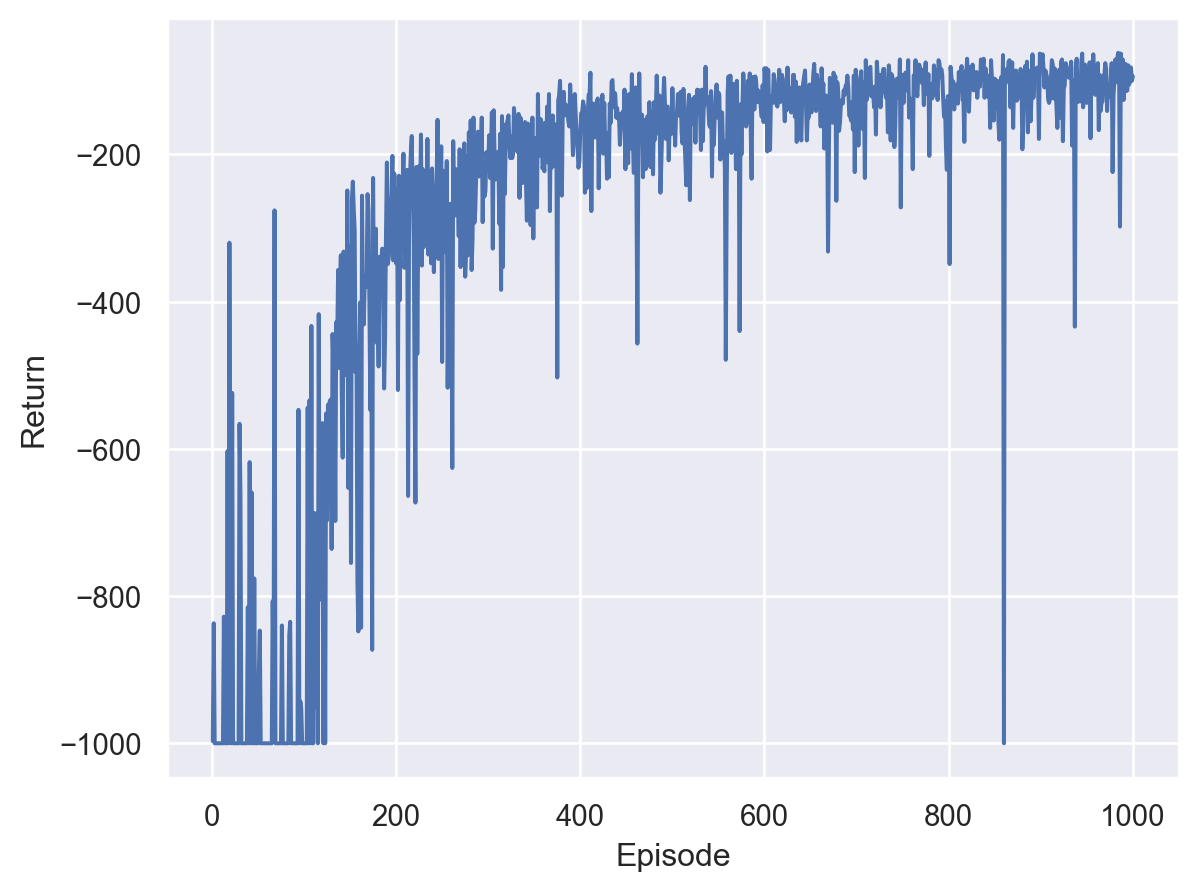

In [13]:
(
    so.Plot(
        data=pd.DataFrame({'Return': returns, 'Episode': range(1, len(returns)+1)}),
        x='Episode',
        y='Return'
    )
    .add(so.Line())
)

All being well, the agent will have figured out how to get the Acrobot's free end above its target height - at which point the episode terminates. You should be able to watch it in action in the animation below:

Learned policy return: -70.00


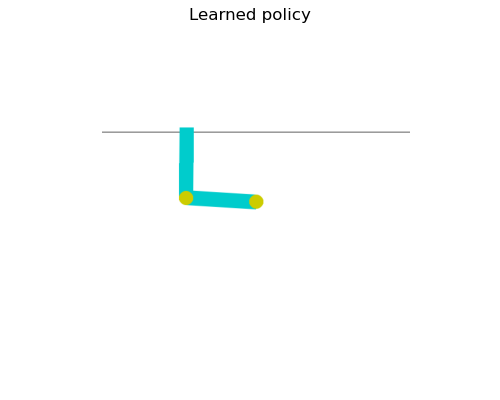

In [15]:
def get_learned_policy_as_animation_frames(agent, env, ax, max_t=1000):
    """Convert agent's learned policy into an animation
    
    Params
    ======
        agent: a trained DQN_agent agent
        env: the environment the agent has been trained on
        ax: a pyplot axis object on which to display the animation
        max_t (int): maximum number of timesteps for the animation to run

    Returns
    =======
        list of animation frames rendered on the supplied pyplot axis
    """

    # We don't want to do any further exploration, so we set the explore_rate to zero:
    explore_rate = 0
    # Initialise the environment, and show its initial state on the pyplot axis:
    state, prob = env.reset()
    ax.imshow(env.render())
    # Store subsequent frames and track final learned policy return
    frames = []
    learned_policy_return = 0
    for t in range(max_t):
        action = agent.policy(state, explore_rate)
        next_state, reward, done, info, prob = env.step(action)

        frame = ax.imshow(env.render(), animated=True)
        frames.append([frame])
            
        state = next_state
        learned_policy_return += reward
        if done:
            break
    
    print(f'Learned policy return: {learned_policy_return:.2f}')
    return frames

fig, ax = plt.subplots(figsize=(5, 4))
plt.axis('off')
plt.suptitle('Learned policy')
frames = get_learned_policy_as_animation_frames(agent, env, ax)
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat=False);

### Assignment questions:

1. How does varying `GAMMA` or `LR` affect performance?
2. What happens if you set `TAU` to 1, i.e. perform hard instead of soft updates, or change `UPDATE_EVERY` to 1?
3. What changes do you need to make to the code to have the agent learn instead from the [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) environment?

### Solutions: 

1.

Gamma: 0.9; learning rate: 1e-06
Gamma: 0.9; learning rate: 1e-05
Gamma: 0.9; learning rate: 0.0001
Gamma: 0.9; learning rate: 0.001
Gamma: 0.9; learning rate: 0.01
Gamma: 0.925; learning rate: 1e-06
Gamma: 0.925; learning rate: 1e-05
Gamma: 0.925; learning rate: 0.0001
Gamma: 0.925; learning rate: 0.001
Gamma: 0.925; learning rate: 0.01
Gamma: 0.95; learning rate: 1e-06
Gamma: 0.95; learning rate: 1e-05
Gamma: 0.95; learning rate: 0.0001
Gamma: 0.95; learning rate: 0.001
Gamma: 0.95; learning rate: 0.01
Gamma: 0.975; learning rate: 1e-06
Gamma: 0.975; learning rate: 1e-05
Gamma: 0.975; learning rate: 0.0001
Gamma: 0.975; learning rate: 0.001
Gamma: 0.975; learning rate: 0.01
Gamma: 1.0; learning rate: 1e-06
Gamma: 1.0; learning rate: 1e-05
Gamma: 1.0; learning rate: 0.0001
Gamma: 1.0; learning rate: 0.001
Gamma: 1.0; learning rate: 0.01


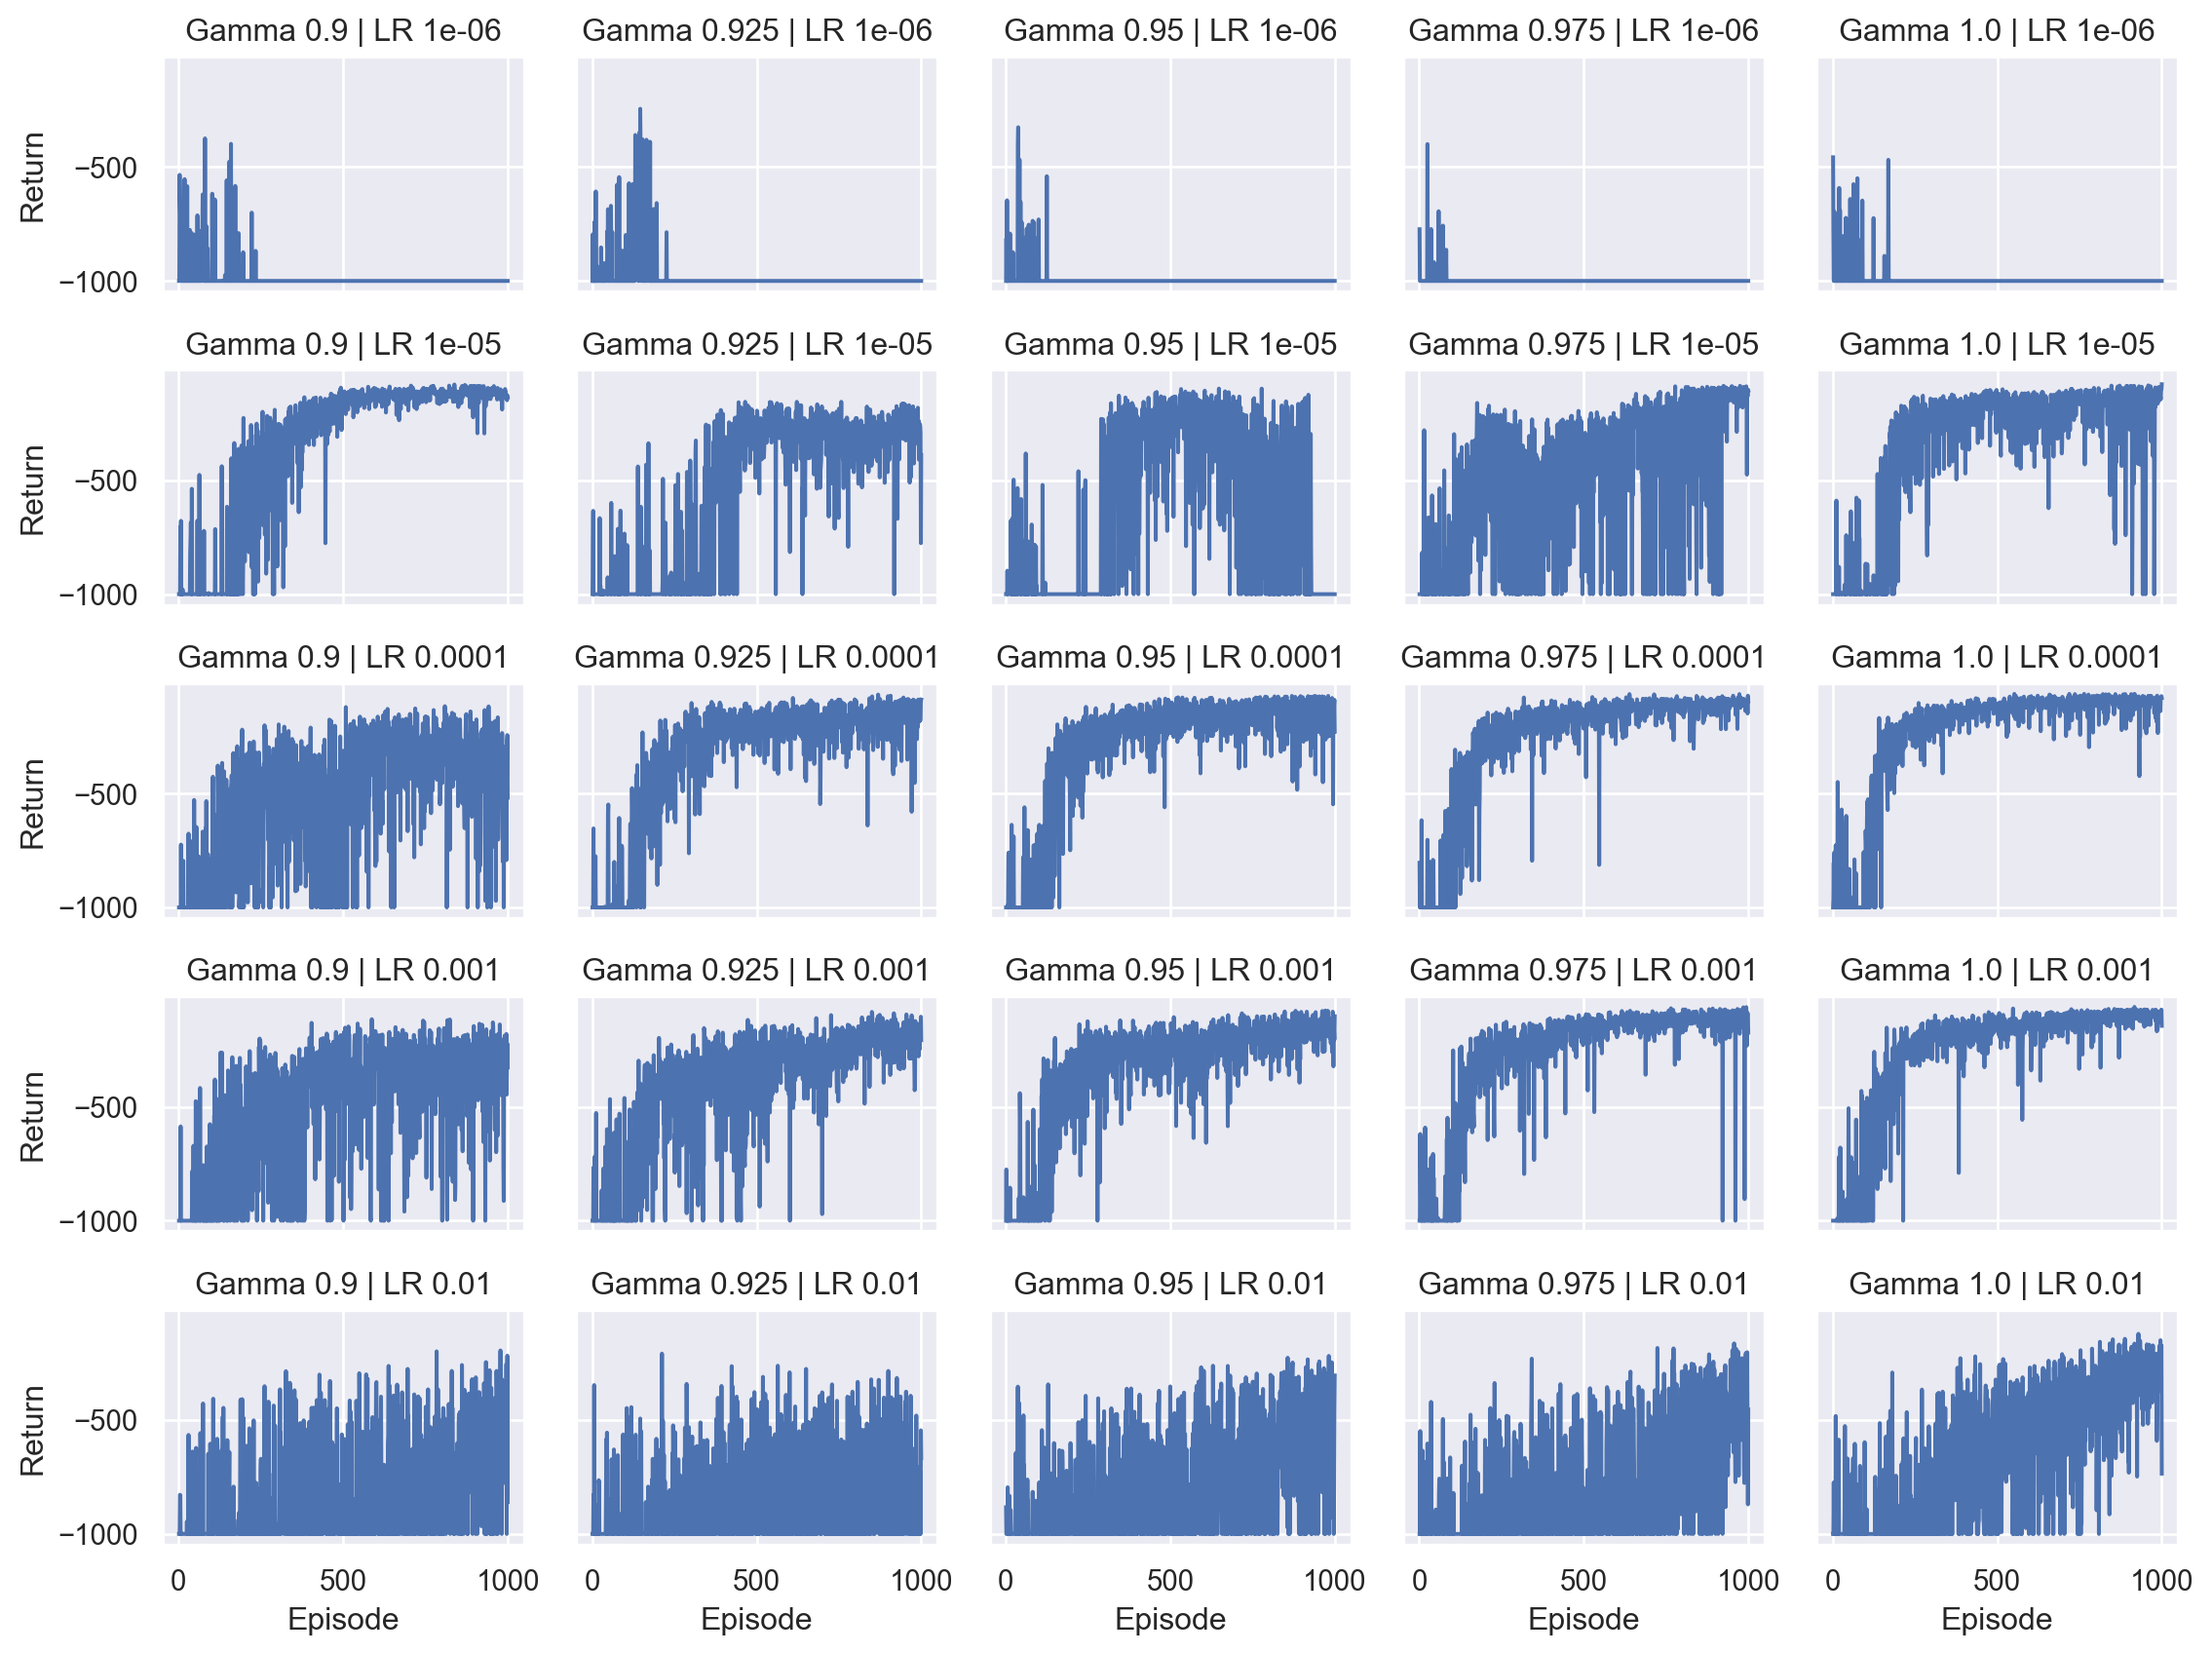

In [42]:
dfs = []
n_episodes = 1000
for GAMMA in np.linspace(0.9, 1.0, 5):
    for LR in np.logspace(-6, -2, 5):
        print(f'Gamma: {GAMMA}; learning rate: {LR}')
        agent = DQN_agent(state_size=6, action_size=3)
        returns = train_DQN(agent, env, n_episodes=n_episodes, verbose=False)
        dfs.append(pd.DataFrame({
            'Gamma': GAMMA,
            'LR': LR,
            'Episode': range(1, n_episodes+1),
            'Return': returns
        }))
df = pd.concat(dfs).reset_index()
(
    so.Plot(df, 'Episode', 'Return')
    .facet('Gamma', 'LR')
    .add(so.Lines())
    .layout(size=(12, 9))
    .label(col="{}".format, row="{}".format)
)

The parameter values that we initially used for training were `GAMMA = 0.99` and `LR = 5e-4`, and these choices do seem to be vindicated by the chart above. If the learning rate is too low, e.g. 1e-6, the model never sees good returns, and if it's too high, e.g. 0.01, the model needs the value for gamma to be high too - even 1.0 - before it is really able to get going, and even then it learns from the environment much more slowly. 

The most interesting part of the chart above is the middle, which shows that there is a correlation between these parameter values and performance: the model will perform well with lower a learning rate if gamma is also set a bit lower, and similarly will also do well if both parameters are set a bit higher; it is when one is high and the other is low that performance starts to nose-dive. 

2.

Tau: 0.0001; update every: 1
Tau: 0.0001; update every: 2
Tau: 0.0001; update every: 3
Tau: 0.0001; update every: 4
Tau: 0.0001; update every: 5
Tau: 0.001; update every: 1
Tau: 0.001; update every: 2
Tau: 0.001; update every: 3
Tau: 0.001; update every: 4
Tau: 0.001; update every: 5
Tau: 0.01; update every: 1
Tau: 0.01; update every: 2
Tau: 0.01; update every: 3
Tau: 0.01; update every: 4
Tau: 0.01; update every: 5
Tau: 0.1; update every: 1
Tau: 0.1; update every: 2
Tau: 0.1; update every: 3
Tau: 0.1; update every: 4
Tau: 0.1; update every: 5
Tau: 1.0; update every: 1
Tau: 1.0; update every: 2
Tau: 1.0; update every: 3
Tau: 1.0; update every: 4
Tau: 1.0; update every: 5


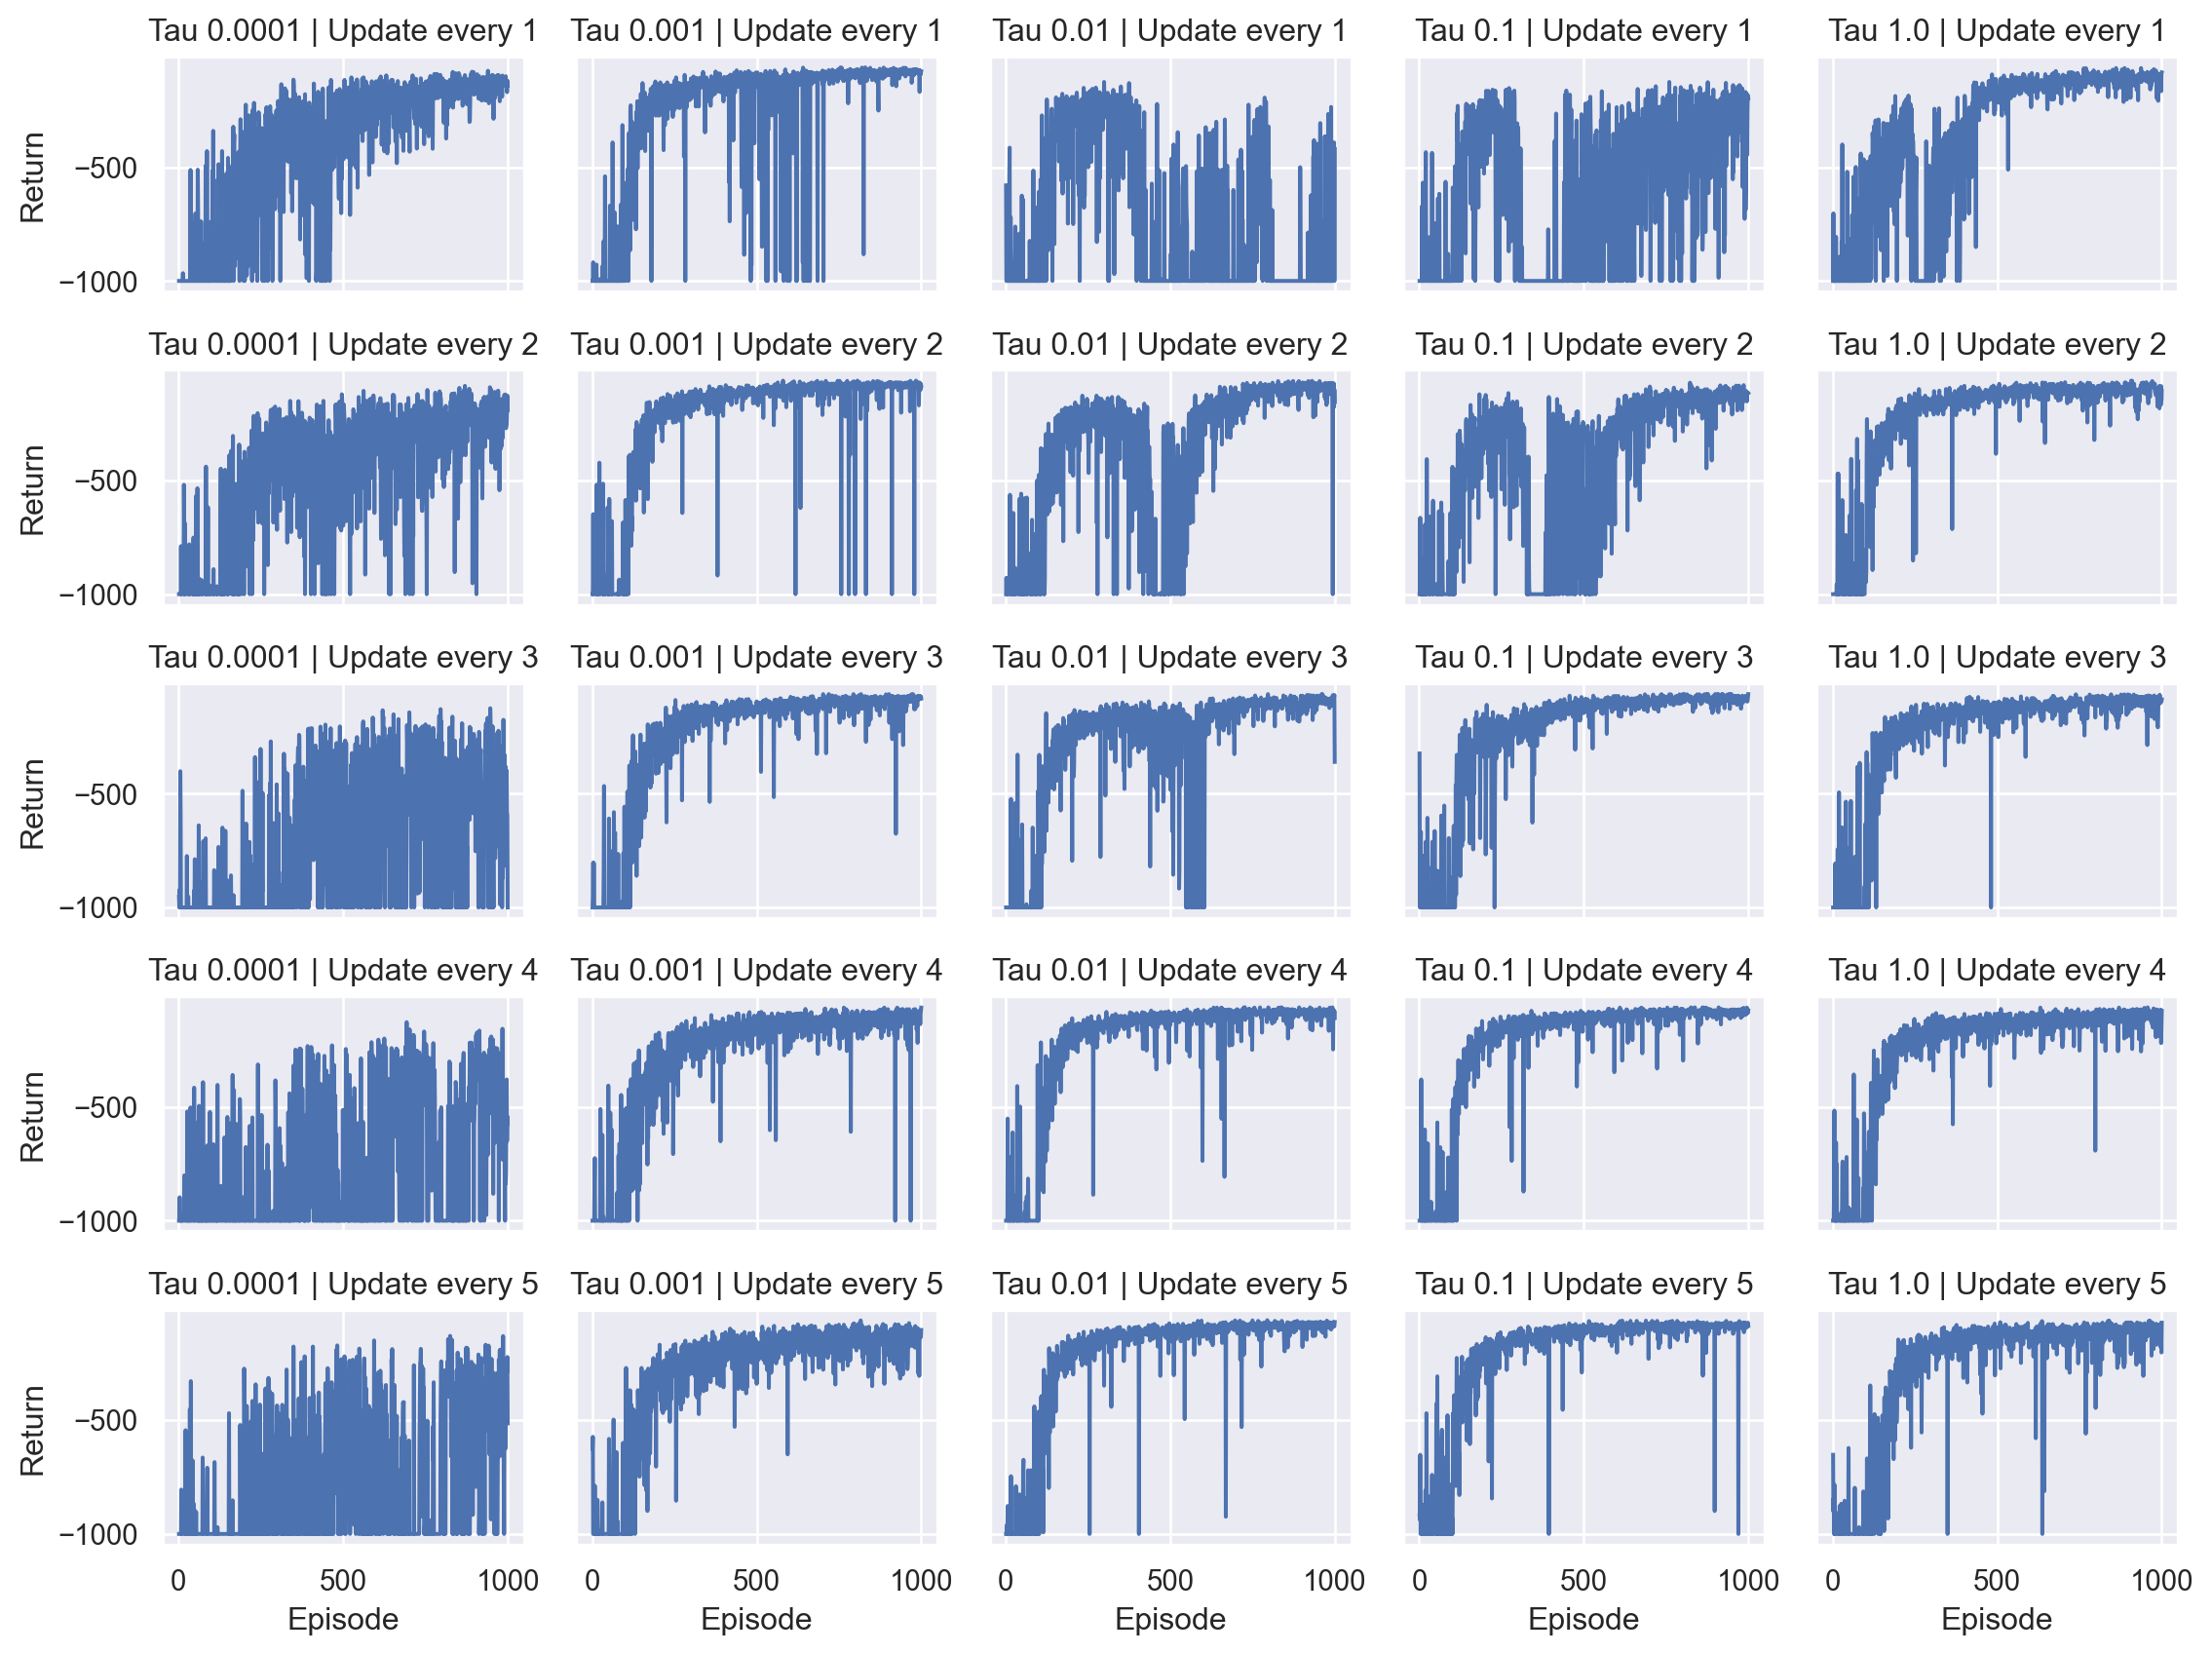

In [43]:
GAMMA = 0.99
LR = 5e-4

dfs = []
n_episodes = 1000
for TAU in np.logspace(-4, 0, 5):
    for UPDATE_EVERY in range(1, 6):
        print(f'Tau: {TAU}; update every: {UPDATE_EVERY}')
        agent = DQN_agent(state_size=6, action_size=3)
        returns = train_DQN(agent, env, n_episodes=n_episodes, verbose=False)
        dfs.append(pd.DataFrame({
            'Tau': TAU,
            'Update every': UPDATE_EVERY,
            'Episode': range(1, n_episodes+1),
            'Return': returns
        }))
df = pd.concat(dfs).reset_index()
(
    so.Plot(df, 'Episode', 'Return')
    .facet('Tau', 'Update every')
    .add(so.Lines())
    .layout(size=(12, 9))
    .label(col="{}".format, row="{}".format)
)

This chart also bolsters our initial choice of parameters of `TAU = 1e-3` and `UPDATE_EVERY = 4`. A hard update (`TAU = 1`) only seems to cause real problems when the target Q network is updated every single time step, and even then the model performed well in this instance given sufficient training time. 

In general, the line charts above show more erratic performance when the `UPDATE_EVERY` parameter is set below 3, and consistently poor performance when tau is set to 1e-4.

3. There are only a few tweaks we need to make to the code to get it learning from a different gymnasium environment. The documentation tells me that the action space for `Cart Pole` is of size two and the observation space has four variables, so the following tweaks should do the trick - we just need to reset the parameters first:

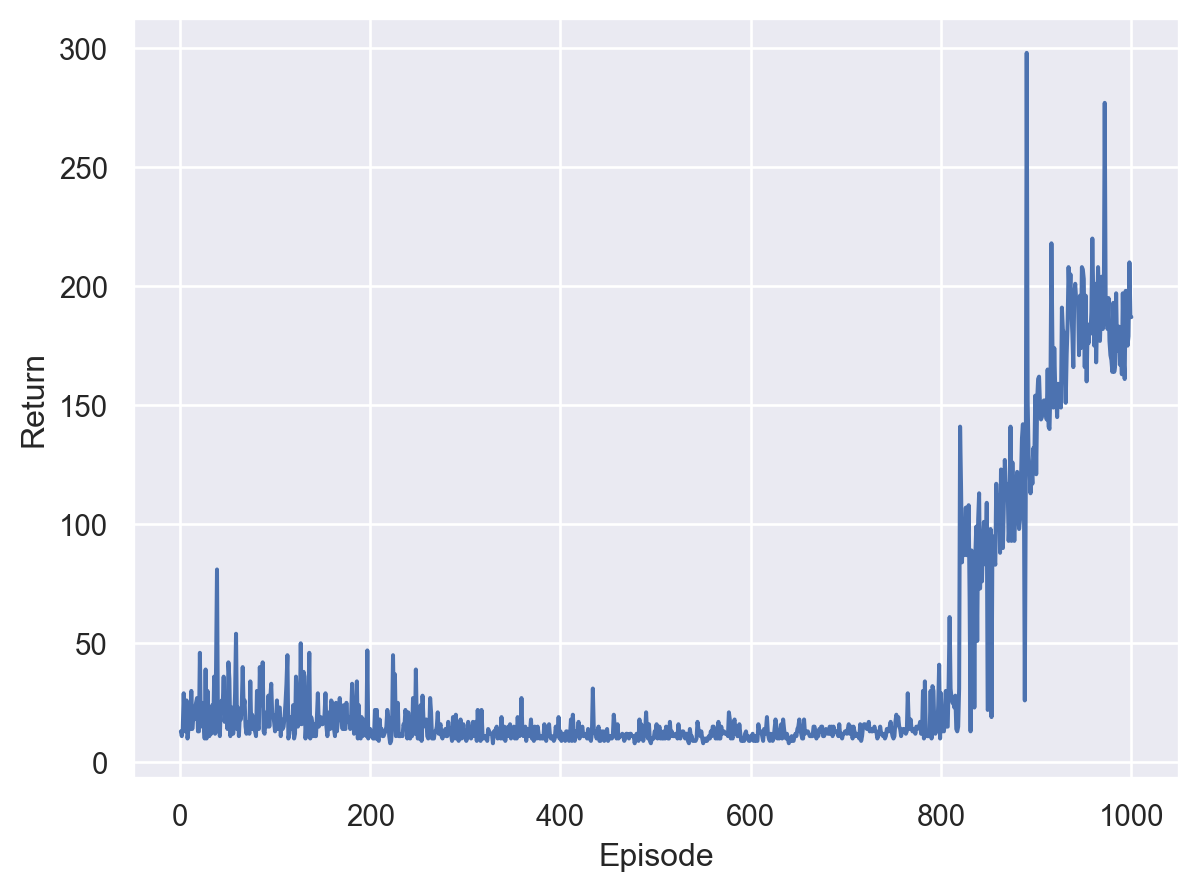

In [49]:
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
TAU = 1e-3              # for soft update of target parameters
UPDATE_EVERY = 4        # how often to update the network

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent = DQN_agent(state_size=4, action_size=2)
returns = train_DQN(agent, env, n_episodes=1000, verbose=False)
(
    so.Plot(
        data=pd.DataFrame({'Return': returns, 'Episode': range(1, len(returns)+1)}),
        x='Episode',
        y='Return'
    )
    .add(so.Line())
)

Feel free to tweak the parameter values - and even the architecture of the network - to see if you can get the cart balancing the pole for longer!

Learned policy return: 195.00


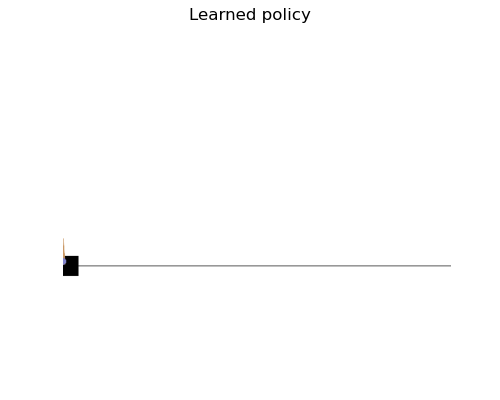

In [50]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.axis('off')
plt.suptitle('Learned policy')
frames = get_learned_policy_as_animation_frames(agent, env, ax)
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat=False);

### Key points

- Neural networks can be used as universal function approximators, and are therefore able to help a computer agent learn from a complex environment involving continuous variables in the observation space
- The way that a DQN agent learns is sensitive to the configuration of some key parameters, such as the learning rate and discount factor
- Network architecture that performs well in one problem space may also be applicable to others, with minimal changes